In [1]:
# Import required packages
from transformers import pipeline, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Import metrics libraries
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
interactions_train = pd.read_csv('https://raw.githubusercontent.com/halim-y/DSML_Kaggle_Competition/refs/heads/main/data/raw/interactions_train.csv')
items = pd.read_csv('https://raw.githubusercontent.com/halim-y/DSML_Kaggle_Competition/refs/heads/main/data/raw/items.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/halim-y/DSML_Kaggle_Competition/refs/heads/main/data/raw/sample_submission.csv')

In [4]:
interactions_train.head()

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


In [5]:
items.head()

,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [6]:
sample_submission.head()

,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [9]:
print(interactions_train['i'].isin(items['i']).mean())

1.0


Since it returns 1.0, we know that "i" is indeed the item/book ID.

Let's rename our columns for more clarity

In [10]:
interactions_train = interactions_train.rename(columns={
    'u': 'user_id',
    'i': 'item_id',
    't': 'timestamp'
})
items = items.rename(columns={'i': 'item_id'})

# 3. sample_submission - EDA

`sample_submission.csv` – example of the correct submission format

1. Inspect Structure

In [13]:
sample_submission.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7838 entries, 0 to 7837
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         7838 non-null   int64 
 1   recommendation  7838 non-null   object
dtypes: int64(1), object(1)
memory usage: 122.6+ KB


In [14]:
sample_submission.isna().sum()


,0
user_id,0
recommendation,0


2. Explore the 'recommendation' column

In [20]:
# show first few values
sample_submission['recommendation'].head()

,recommendation
0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [22]:
# Example: split the first row into individual item_ids
example_list = str(sample_submission['recommendation'].iloc[0]).split()
example_list[:10]


['3758',
 '11248',
 '9088',
 '9895',
 '5101',
 '6074',
 '9295',
 '14050',
 '10961',
 '8240']

3. Number of items per user

In [23]:
# Count number of items per user
sample_submission["num_items"] = (
    sample_submission["recommendation"].astype(str).apply(lambda x: len(x.split()))
)

sample_submission["num_items"].describe()


,num_items
count,7838.0
mean,10.0
std,0.0
min,10.0
25%,10.0
50%,10.0
75%,10.0
max,10.0


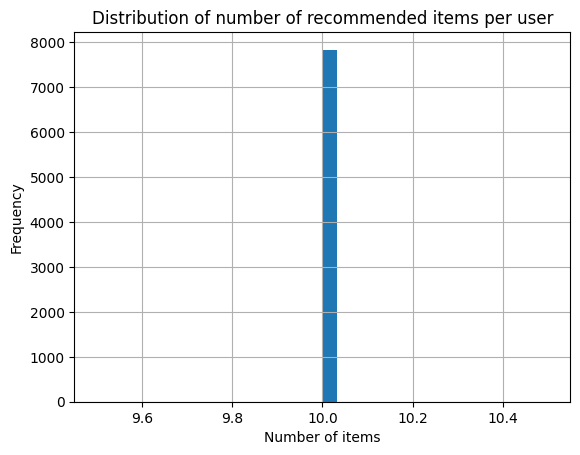

In [24]:
sample_submission["num_items"].hist(bins=30)
plt.title("Distribution of number of recommended items per user")
plt.xlabel("Number of items")
plt.ylabel("Frequency")
plt.show()


4. Check user coverage

In [25]:
train_users = set(interactions_train["user_id"].unique())
test_users = set(sample_submission["user_id"].unique())

print("Users in train:", len(train_users))
print("Users in sample_submission:", len(test_users))
print("Users in train but not in sample_submission:", len(train_users - test_users))
print("Users in sample_submission but not in train:", len(test_users - train_users))


Users in train: 7838
Users in sample_submission: 7838
Users in train but not in sample_submission: 0
Users in sample_submission but not in train: 0


5. Create a Dummy baseline submission

In [26]:
dummy_items = "1 2 3 4 5"

dummy_submission = sample_submission.copy()
dummy_submission["recommendation"] = dummy_items
dummy_submission.head()


,user_id,recommendation,num_items
0,0,1 2 3 4 5,10
1,1,1 2 3 4 5,10
2,2,1 2 3 4 5,10
3,3,1 2 3 4 5,10
4,4,1 2 3 4 5,10


6. Save dummy submission to /results/submissions/

In [29]:


os.makedirs("../results/submissions", exist_ok=True)

output_path = "../results/submissions/sample_submission_test.csv"
dummy_submission.to_csv(output_path, index=False)

output_path

'../results/submissions/sample_submission_test.csv'

7. Sanity checks

In [27]:
#Check for commas (Kaggle would reject)
contains_commas = dummy_submission["recommendation"].astype(str).apply(lambda x: "," in x).sum()
print("Rows with commas in recommendation:", contains_commas)
#Ensure all users unique
print("Unique users =", dummy_submission["user_id"].nunique())
print("Total rows    =", len(dummy_submission))


Rows with commas in recommendation: 0
Unique users = 7838
Total rows    = 7838
